In [1]:
import pandas as pd
import numpy as np                          # 계산 패키지
import matplotlib.pyplot as plt             # 데이터 시각화 패키지
import seaborn as sns                       # 데이터 시각화 패키지

import xgboost as xgb                       # XGBoost 패키지
from sklearn.model_selection import KFold   # K-Fold CV

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('./data/train_fixv.csv')
test = pd.read_csv('./data/test_fixv.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,...,3.227782e-19,0.000000e+00,5.337522e-19,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,...,1.343132e-08,6.112685e-09,2.130547e-09,5.920319e-09,9.710091e-09,9.710091e-09,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,1.329725e-18,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,...,2.245998e-10,1.299511e-10,7.782625e-11,2.433592e-10,4.088921e-10,4.088921e-10,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,...,1.457955e-13,8.769053e-14,1.103571e-13,1.330237e-13,1.330237e-13,1.330237e-13,11.97,4.41,10.78,2.42


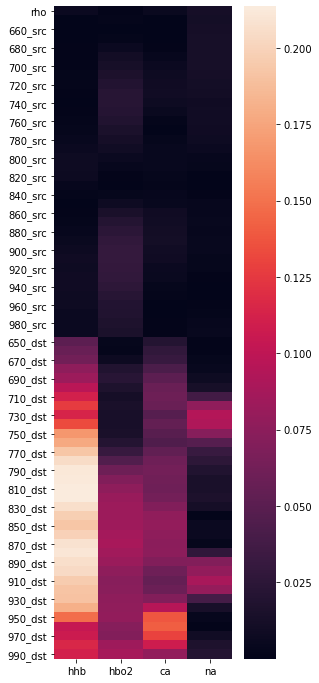

In [4]:
plt.figure(figsize=(4,12))
sns.heatmap(train.corr().loc['rho':'990_dst','hhb':].abs())

In [5]:
x_train = train.loc[:, '650_dst':'990_dst']
y_train = train.loc[:, 'hhb':'na']
x_train.shape, y_train.shape

((10000, 35), (10000, 4))

In [63]:
def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=106)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = xgb.DMatrix(data = x_train, label = y_train)
        d_val = xgb.DMatrix(data = x_val, label = y_val)
        
        wlist = [(d_train, 'train'), (d_val, 'eval')]
        
        params = {
            'max_depth' : 5,
            'min_child_weight' : 2,
            'eta' : 0.1,
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'seed':777
            }

        model = xgb.train(params=params, dtrain=d_train, num_boost_round=350, verbose_eval=500, evals=wlist)
        models.append(model)
    
    return models

In [58]:
#5,2,0.1,400
models = {}
for label in y_train.columns:
    print('train column : ', label)
    models[label] = train_model(x_train, y_train[label])

train column :  hhb
[0]	train-mae:6.74816	eval-mae:6.81533
[399]	train-mae:0.72749	eval-mae:1.66758
[0]	train-mae:6.73951	eval-mae:6.84936
[399]	train-mae:0.73118	eval-mae:1.62726
[0]	train-mae:6.76903	eval-mae:6.72144
[399]	train-mae:0.73461	eval-mae:1.60086
[0]	train-mae:6.76926	eval-mae:6.72574
[399]	train-mae:0.72103	eval-mae:1.67989
[0]	train-mae:6.77358	eval-mae:6.69554
[399]	train-mae:0.72449	eval-mae:1.65232
train column :  hbo2
[0]	train-mae:3.15764	eval-mae:3.17008
[399]	train-mae:0.35179	eval-mae:0.74295
[0]	train-mae:3.15962	eval-mae:3.15761
[399]	train-mae:0.35527	eval-mae:0.72340
[0]	train-mae:3.15736	eval-mae:3.16863
[399]	train-mae:0.35514	eval-mae:0.74042
[0]	train-mae:3.16045	eval-mae:3.15498
[399]	train-mae:0.35657	eval-mae:0.73093
[0]	train-mae:3.16242	eval-mae:3.14614
[399]	train-mae:0.35696	eval-mae:0.75120
train column :  ca
[0]	train-mae:7.70146	eval-mae:7.55165
[399]	train-mae:1.02783	eval-mae:2.08471
[0]	train-mae:7.67189	eval-mae:7.67474
[399]	train-mae:1.007

In [64]:
#5,2,0.1,350
models = {}
for label in y_train.columns:
    print('train column : ', label)
    models[label] = train_model(x_train, y_train[label])

train column :  hhb
[0]	train-mae:6.74816	eval-mae:6.81533
[349]	train-mae:0.78882	eval-mae:1.67113
[0]	train-mae:6.73951	eval-mae:6.84936
[349]	train-mae:0.78885	eval-mae:1.63211
[0]	train-mae:6.76903	eval-mae:6.72144
[349]	train-mae:0.79295	eval-mae:1.60119
[0]	train-mae:6.76926	eval-mae:6.72574
[349]	train-mae:0.78705	eval-mae:1.68513
[0]	train-mae:6.77358	eval-mae:6.69554
[349]	train-mae:0.78204	eval-mae:1.65049
train column :  hbo2
[0]	train-mae:3.15764	eval-mae:3.17008
[349]	train-mae:0.37924	eval-mae:0.74306
[0]	train-mae:3.15962	eval-mae:3.15761
[349]	train-mae:0.38326	eval-mae:0.72113
[0]	train-mae:3.15736	eval-mae:3.16863
[349]	train-mae:0.38102	eval-mae:0.73896
[0]	train-mae:3.16045	eval-mae:3.15498
[349]	train-mae:0.38341	eval-mae:0.73152
[0]	train-mae:3.16242	eval-mae:3.14614
[349]	train-mae:0.38417	eval-mae:0.74932
train column :  ca
[0]	train-mae:7.70146	eval-mae:7.55165
[349]	train-mae:1.11389	eval-mae:2.08358
[0]	train-mae:7.67189	eval-mae:7.67474
[349]	train-mae:1.095

In [65]:
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(xgb.DMatrix(test.loc[:, '650_dst':])))
    pred = np.mean(preds, axis=0)

    submission[col] = pred

In [66]:
submission.to_csv('Dacon_baseline_j2.csv', index=False)